# Plot Fig 3

## Hide or show code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import packages

In [2]:
import matplotlib.pyplot as mp
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.gridspec as gs
import numpy as np
import pickle as pc
from scipy.optimize import minimize
from pyabc import History

## Read data

In [3]:
# Load true parameter values
with open('../data/LV/simulation_parameters.pickle', 'rb') as f: 
    true_parameters = pc.load(f)

par = np.array([true_parameters['gR'][0], true_parameters['gR'][1], true_parameters['gR'][2],
         true_parameters['I'][0,0], true_parameters['I'][0,1], true_parameters['I'][0,2],
         true_parameters['I'][1,0], true_parameters['I'][1,1], true_parameters['I'][1,2],
         true_parameters['I'][2,0], true_parameters['I'][2,1], true_parameters['I'][2,2]
         ])

# Load outcome of ABC inference and extract the posterior distribution
# Here "even" means that moments were not rescaled during the ABC inference
data_even = History("sqlite:///../data/LV/inference_rel_abund_even.db")
posterior_even = data_even.get_distribution()[0]

# Load simulated data to use for the linear regression
with open('../data/LV/simulation_abs_abund.pickle', 'rb') as f: 
    LV_sim = pc.load(f)
LV_data = LV_sim['data']

# Define the independent variables (X) and dependent variable (y)
# for the linear regression of the Lotka-Volterra model as indicated 
# in Stein RR, et al, 2013 (https://doi.org/10.1371/journal.pcbi.1003388).
X = LV_data['moments'][1:,:3]
y = np.log(LV_data['moments'][1:,:3]) - np.log(LV_data['moments'][:-1,:3])
print(X), print(y)

[[ 1306.   22868.5  12325.75]
 [ 3534.5  29445.25  8776.75]
 [ 9669.25 28123.25  7345.  ]
 [17506.75 24910.5   7970.5 ]
 [20532.   23225.   10164.75]]
[[ 0.62364397  1.18385027  0.02678392]
 [ 0.99560282  0.25277219 -0.33958439]
 [ 1.0063789  -0.04593597 -0.17808637]
 [ 0.59363577 -0.12130724  0.08172742]
 [ 0.15939812 -0.07006012  0.24317863]]


(None, None)

## Linear regression of the Lotka-Volterra model

In [4]:
# Set the regularization coefficients (0 indicates no regularization)
reg_gR, reg_I = 0, 0

# Define the Lotka-Volterra model with regularization
def lin_reg_regularization(par):
    
    gR = par[:3]
    I = par[3:].reshape(3,3)
    
    errors = (np.matmul(X,I.T) + gR) - y
    
    linear_regression = np.sqrt((errors**2).sum())
    regularization_gR = reg_gR * np.sqrt((gR**2).sum())
    regularization_I = reg_I * np.sqrt((I**2).sum())
    
    return linear_regression + regularization_gR + regularization_I

# Define the initial guess for the linear regression
init_guess = np.array([1.5, 1.5, 1.5,
                       -1E-4, 0, 0,
                       0, -1E-4, 0,
                       0, 0, -1E-4])

# Linear regression with regularization to infer the parameters from data 
sol = minimize(lin_reg_regularization, x0 = init_guess, method='L-BFGS-B')

# Extract the inferred parameters from the linear regression
lin_reg_inference = {'gR_0': sol.x[0], 'I_0_0': sol.x[3], 'I_0_1': sol.x[4], 'I_0_2': sol.x[5], 
                     'gR_1': sol.x[1], 'I_1_0': sol.x[6], 'I_1_1': sol.x[7], 'I_1_2': sol.x[8], 
                     'gR_2': sol.x[2], 'I_2_0': sol.x[9], 'I_2_1': sol.x[10], 'I_2_2': sol.x[11]}

## Plot and save figure

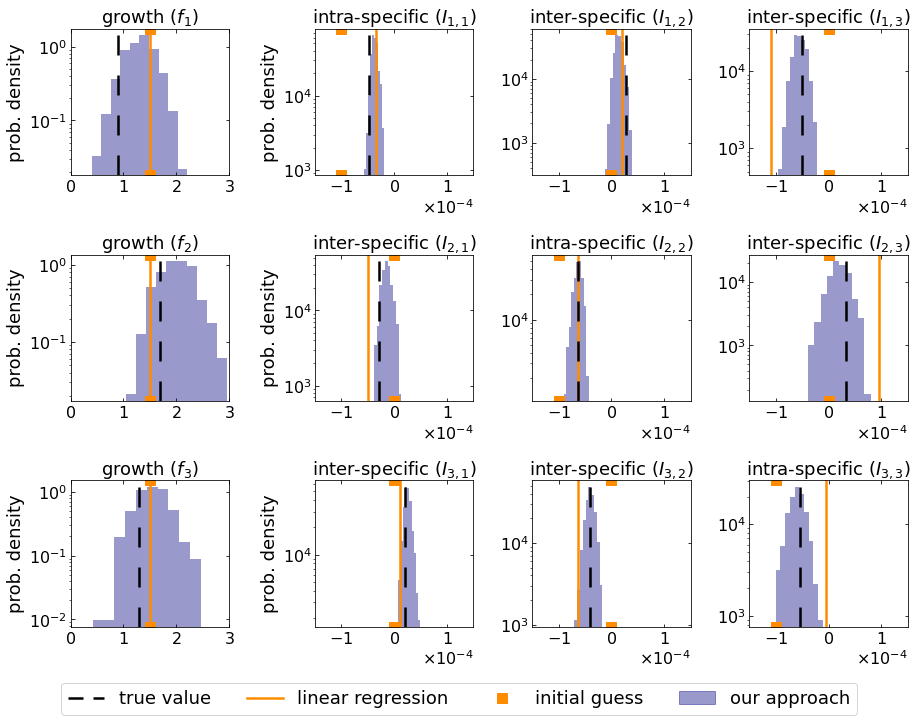

In [5]:
# Make figure (Fig 3)
fig = mp.figure(figsize=(15, 11))

# Create array to build figure panels
gs0 = gs.GridSpec(24, 31, figure=fig)

axA00 = fig.add_subplot(gs0[:6, :6])
axA01 = fig.add_subplot(gs0[9:15, :6])
axA02 = fig.add_subplot(gs0[18:, :6])

axA10 = fig.add_subplot(gs0[:6, 9:15])
axA11 = fig.add_subplot(gs0[9:15, 9:15])
axA12 = fig.add_subplot(gs0[18:, 9:15])

axA20 = fig.add_subplot(gs0[:6, 17:23])
axA21 = fig.add_subplot(gs0[9:15, 17:23])
axA22 = fig.add_subplot(gs0[18:, 17:23])

axA30 = fig.add_subplot(gs0[:6, 25:])
axA31 = fig.add_subplot(gs0[9:15, 25:])
axA32 = fig.add_subplot(gs0[18:, 25:])

# Define panel for each parameter to show
par_loc = {'gR_0': axA00, 'I_0_0': axA10, 'I_0_1': axA20, 'I_0_2': axA30, 
           'gR_1': axA01, 'I_1_0': axA11, 'I_1_1': axA21, 'I_1_2': axA31, 
           'gR_2': axA02, 'I_2_0': axA12, 'I_2_1': axA22, 'I_2_2': axA32}

# Plot inference outcomes
for par in par_loc.keys():
    # Plot posterior distribution of the ABC inference
    par_loc[par].hist(posterior_even.loc[:,par], color = 'navy', alpha = 0.4, density=True, bins = 10, log=True)
    # Plot inferred value of the linear regression
    par_loc[par].axvline(lin_reg_inference[par], color='darkorange', linestyle='-', linewidth=2.5)

# Plot initial guess of the parameters
# Growth rates
for ax in [axA00,axA01,axA02]:
    ax.axvline(1.5, color='darkorange', linestyle='', marker='s', markersize=10)
# Intra-specific interactions
for ax in [axA10,axA21,axA32]:
    ax.axvline(-1E-4, color='darkorange', linestyle='', marker='s', markersize=10)
# Inter-specific interactions
for ax in [axA11,axA12,axA20,axA22,axA30,axA31]:
    ax.axvline(0, color='darkorange', linestyle='', marker='s', markersize=10)

# Plot true value of the parameters
# Growth rates
axA00.axvline(true_parameters['gR'][0],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA01.axvline(true_parameters['gR'][1],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA02.axvline(true_parameters['gR'][2],linestyle=(0,(8,8)),color='k',linewidth=2.5)
# Pair-wise interactions
axA10.axvline(true_parameters['I'][0,0],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA11.axvline(true_parameters['I'][1,0],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA12.axvline(true_parameters['I'][2,0],linestyle=(0,(8,8)),color='k',linewidth=2.5)

axA20.axvline(true_parameters['I'][0,1],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA21.axvline(true_parameters['I'][1,1],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA22.axvline(true_parameters['I'][2,1],linestyle=(0,(8,8)),color='k',linewidth=2.5)

axA30.axvline(true_parameters['I'][0,2],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA31.axvline(true_parameters['I'][1,2],linestyle=(0,(8,8)),color='k',linewidth=2.5)
axA32.axvline(true_parameters['I'][2,2],linestyle=(0,(8,8)),color='k',linewidth=2.5)

# General setup of the figure panels
for ax in [axA00,axA01,axA02]:
    ax.set_xlim(0,3)

for ax in [axA10,axA11,axA12,axA20,axA21,axA22,axA30,axA31,axA32]:
    ax.set_xlim(-1.5E-4, 1.5E-4)

for ax in [axA00,axA01,axA02,axA10,axA11,axA12,axA20,axA21,axA22,axA30,axA31,axA32]:
    ax.tick_params(axis='both', direction='in',top=True, right=True)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set(size=16)
    
for ax in [axA00,axA01,axA02,axA10,axA11,axA12]:
    ax.set_ylabel("prob. density", fontsize=18)
    
axA00.set_title(r'growth ($f_1$)', fontsize=18)
axA01.set_title(r'growth ($f_2$)', fontsize=18)
axA02.set_title(r'growth ($f_3$)', fontsize=18)

axA10.set_title(r'intra-specific ($I_{1,1}$)', fontsize=18)
axA11.set_title(r'inter-specific ($I_{2,1}$)', fontsize=18)
axA12.set_title(r'inter-specific ($I_{3,1}$)', fontsize=18)

axA20.set_title(r'inter-specific ($I_{1,2}$)', fontsize=18)
axA21.set_title(r'intra-specific ($I_{2,2}$)', fontsize=18)
axA22.set_title(r'inter-specific ($I_{3,2}$)', fontsize=18)

axA30.set_title(r'inter-specific ($I_{1,3}$)', fontsize=18)
axA31.set_title(r'inter-specific ($I_{2,3}$)', fontsize=18)
axA32.set_title(r'intra-specific ($I_{3,3}$)', fontsize=18)

# Make a shared legend for the figure
# True parameter value
true_line = Line2D([0],[0], linestyle=(0,(6,4)), color='k', linewidth=2.5, label='true value')
# Posterior distribution of the ABC inference
even_patch = mpatches.Patch(color = 'navy', alpha = 0.4, label='our approach')
# Inferred value of the linear regression
lin_reg_line = Line2D([0],[0], linestyle='-', color='darkorange', linewidth=2.5, label=r'linear regression')
# Initial guess of the linear regression
init_guess_line = Line2D([0],[0], linestyle='', color='darkorange', marker='s', markersize=10, linewidth=2.5, label=r'initial guess')
fig.legend(handles=[true_line, lin_reg_line, init_guess_line, even_patch], loc='lower center', ncol=4, prop=dict(size=18))

# Save figure
mp.savefig('fig3.pdf', dpi=300, format='pdf', bbox_inches='tight')